In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GINConv, global_mean_pool, global_add_pool
from torch_geometric.loader import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from community import community_louvain

from autoencoder import GIN, Decoder
from denoise_model import DenoiseNN, p_losses, sample, SinusoidalPositionEmbeddings
from utils import linear_beta_schedule, preprocess_dataset

import csv
from utils import construct_nx_from_adj

import networkx as nx

import math

# Datasets

In [7]:
train_dataset = torch.load('../data/dataset_train.pt')
valid_dataset = torch.load('../data/dataset_valid.pt')
test_dataset = torch.load('../data/dataset_test.pt')

/tmp/ipykernel_1200984/2199078535.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load('../data/dataset_train.pt')
/tmp/ipykernel_1200984/219907853

We compute the mean and the standard deviation of the statistics in the training dataset to normalize the inputs to the decoder later on

In [8]:
stats = [graph.stats for graph in train_dataset]
stats = torch.stack(stats).squeeze()
stats_mean = stats.mean(dim=0)
stats_std = stats.std(dim=0)
stats_mean, stats_std

(tensor([3.0606e+01, 2.2626e+02, 1.2925e+01, 1.3899e+03, 5.0697e-01, 1.1442e+01,
         3.3475e+00]),
 tensor([1.1808e+01, 2.3441e+02, 1.0175e+01, 2.7951e+03, 3.2121e-01, 9.9933e+00,
         1.4503e+00]))

# Scoring

In [9]:
def handle_nan(x):
    if math.isnan(x):
        return float(-100)
    return x


def calculate_stats_graph(G):
    stats = []
    # Number of nodes
    num_nodes = handle_nan(float(G.number_of_nodes()))
    stats.append(num_nodes)
    # Number of edges
    num_edges = handle_nan(float(G.number_of_edges()))
    stats.append(num_edges)
    # Degree statistics
    degrees = [deg for node, deg in G.degree()]
    avg_degree = handle_nan(float(sum(degrees) / len(degrees)))
    stats.append(avg_degree)
    # Number of triangles
    triangles = nx.triangles(G)
    num_triangles = handle_nan(float(sum(triangles.values()) // 3))
    stats.append(num_triangles)
    # Global clustering coefficient
    global_clustering_coefficient = handle_nan(float(nx.transitivity(G)))
    stats.append(global_clustering_coefficient)
    # Maximum k-core
    max_k_core = handle_nan(float(max(nx.core_number(G).values())))
    stats.append(max_k_core)
    # calculate communities
    partition = community_louvain.best_partition(G)
    n_communities = handle_nan(float(len(set(partition.values()))))
    stats.append(n_communities)

    return stats



def store_stats(y, y_pred, fw_name1, fw_name2):
    fw1 = open(fw_name1,"w")
    fw2 = open(fw_name2,"w")

    for el in y:
        np.savetxt(fw1, el, newline=' ')
        fw1.write('\n')
    fw1.close()

    for el in y_pred:
        np.savetxt(fw2, el, newline=' ')
        fw2.write('\n')
    fw2.close()



def gen_stats(G):
    y_pred = calculate_stats_graph(G)
    y_pred = np.nan_to_num(y_pred, nan=-100.0)
    return y_pred


def precompute_missing(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    y = np.nan_to_num(y, nan=-100.0)
    y_pred = np.nan_to_num(y_pred, nan=-100.0)
    # Find indices where y is -100
    indices_to_change = np.where(y == -100.0)

    # Set corresponding elements in y and y_pred to 0
    y[indices_to_change] = 0.0
    y_pred[indices_to_change] = 0.0
    zeros_per_column = np.count_nonzero(y, axis=0)

    list_from_array = zeros_per_column.tolist()
    dc = {}
    for i in range(len(list_from_array)):
        dc[i] = list_from_array[i]
    return dc, y, y_pred



def sum_elements_per_column(matrix, dc):
    num_rows = len(matrix)
    num_cols = len(matrix[0])

    column_sums = [0] * num_cols

    for col in range(num_cols):
        for row in range(num_rows):
            column_sums[col] += matrix[row][col]

    res = []
    for col in range(num_cols):
        x = column_sums[col]/dc[col]
        res.append(x)

    return res



def calculate_mean_std(x):

    sm = [0 for i in range(7)]
    samples = [0 for i in range(7)]

    for el in x:
        for i, it in enumerate(el):
            if not math.isnan(it):
                sm[i] += it
                samples[i] += 1

    mean = [k / y for k,y in zip(sm, samples)]


    sm2 = [0 for i in range(7)]

    std = []

    for el in x:
        for i, it in enumerate(el):
            if not math.isnan(it):
                k = (it - mean[i])**2
                sm2[i] += k

    std = [(k / y)**0.5 for k,y in zip(sm2, samples)]
    return mean, std



def evaluation_metrics(y, y_pred, eps=1e-10):
    dc, y, y_pred = precompute_missing(y, y_pred)

    mse_st = (y - y_pred) ** 2
    mae_st = np.absolute(y - y_pred)

    mse = sum_elements_per_column(mse_st, dc)
    mae = sum_elements_per_column(mae_st, dc)

    #mse = [sum(x)/len(mse_st) for x in zip(*mse_st)]
    #mae = [sum(x)/len(mae_st) for x in zip(*mae_st)]

    a = np.absolute(y - y_pred)
    b = np.absolute(y) + np.absolute(y_pred)+ eps
    norm_error_st = (a/b)

    norm_error = sum_elements_per_column(norm_error_st, dc)
    #[sum(x)*100/len(norm_error_st) for x in zip(*norm_error_st)]

    return mse, mae, norm_error


def z_score_norm(y, y_pred, mean, std, eps=1e-10):

    y = np.array(y)
    y_pred = np.array(y_pred)

    normalized_true = (y - mean) / std

    normalized_gen = (y_pred - mean) / std

    dc, normalized_true, normalized_gen = precompute_missing(normalized_true, normalized_gen)

    #print(np.isnan(normalized_true).any())
    #print(np.isnan(normalized_gen).any())

    # Calculate MSE using normalized tensors
    mse_st = (normalized_true - normalized_gen) ** 2
    mae_st = np.absolute(normalized_true - normalized_gen)

    mse = sum_elements_per_column(mse_st, dc)
    mae = sum_elements_per_column(mae_st, dc)

    mse = np.sum(mse)/7
    mae = np.sum(mae)/7

    a = np.absolute(normalized_true - normalized_gen)
    b = np.absolute(normalized_true) + np.absolute(normalized_gen) + eps
    norm_error_st = (a/b)
    norm_error = sum_elements_per_column(norm_error_st, dc)
    norm_error = np.sum(norm_error)/7


    return mse, mae, norm_error

# VAE Model

In [10]:
class condGIN(torch.nn.Module):
    def __init__(self, input_dim, n_cond, hidden_dim, latent_dim, n_layers, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        
        self.convs = torch.nn.ModuleList()
        self.convs.append(GINConv(nn.Sequential(nn.Linear(input_dim + n_cond, hidden_dim),  
                            nn.LeakyReLU(0.2),
                            nn.BatchNorm1d(hidden_dim),
                            nn.Linear(hidden_dim, hidden_dim), 
                            nn.LeakyReLU(0.2))
                            ))                        
        for layer in range(n_layers-1):
            self.convs.append(GINConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim),  
                            nn.LeakyReLU(0.2),
                            nn.BatchNorm1d(hidden_dim),
                            nn.Linear(hidden_dim, hidden_dim), 
                            nn.LeakyReLU(0.2))
                            )) 

        self.bn = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, latent_dim)

        self.stats_mean = stats_mean
        self.stats_std = stats_std
        

    def forward(self, data):
        edge_index = data.edge_index
        x = data.x_stats

        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.dropout(x, self.dropout, training=self.training)

        out = global_add_pool(x, data.batch)
        out = self.bn(out)
        out = self.fc(out)
        return out

In [33]:
class VAE7(nn.Module):

    def __init__(self, input_dim, hidden_dim_enc, hidden_dim_dec, latent_dim, n_layers_enc, n_layers_dec, n_max_nodes):
        super(VAE7, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.encoder = GIN(input_dim, hidden_dim_enc, hidden_dim_enc, n_layers_enc).to(self.device)
        self.fc_mu = nn.Linear(hidden_dim_enc, latent_dim).to(self.device)
        self.fc_logvar = nn.Linear(hidden_dim_enc, latent_dim).to(self.device)
        self.decoder = Decoder(latent_dim + 7, hidden_dim_dec, n_layers_dec, n_max_nodes).to(self.device)

        self.latent_dim = latent_dim

        self.mean = stats_mean.to(self.device)
        self.std = stats_std.to(self.device)


    def forward(self, data):
        z, mu, logvar = self.encode(data)
        stats = (data.stats - self.mean) / self.std
        z_stats = torch.cat([z, stats], dim=1)
        adj = self.decoder(z_stats)
        return adj

    def encode(self, data):
        x_g = self.encoder(data)
        mu = self.fc_mu(x_g)
        logvar = self.fc_logvar(x_g)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + std * eps
        else:
            return mu

    def loss_function(self, data, beta=0.):
        z, mu, logvar = self.encode(data)
        stats = (data.stats - self.mean) / self.std
        z_stats = torch.cat([z, stats], dim=1)
        adj = self.decoder(z_stats)
        
        recon = F.l1_loss(adj, data.A, reduction='mean')
        kld = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim = 1), dim = 0)
        thresh = torch.Tensor([.1]).to(self.device)
        loss = recon + beta * torch.maximum(kld, thresh)

        return loss, recon, kld
    
    def sample(self, stats, z = None):
        num_samples = stats.shape[0]
        if z is None:
            z = torch.randn(num_samples, self.latent_dim).to(self.device)
        stats = (stats - self.mean) / self.std
        z_stats = torch.cat([z, stats], dim=1)
        return self.decoder(z_stats)


In [34]:
input_dim = 11
hidden_dim_enc = 256
hidden_dim_dec = 256
latent_dim = 8
n_layers_enc = 3
n_layers_dec = 3
n_max_nodes = 50

# Training the VAE

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE7(input_dim, hidden_dim_enc, hidden_dim_dec, latent_dim, n_layers_enc, n_layers_dec, n_max_nodes).to(device)

In [36]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [37]:
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

max_epochs = 1000
annealing_epochs = 200
zero_beta_epochs = 0

In [38]:
for epoch in range(max_epochs):
    
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    beta = .5 # min(1, (epoch - zero_beta_epochs) / annealing_epochs) * .005

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss, recon_loss, kl_loss = model.loss_function(data, beta = beta)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.decoder.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()

    train_loss /= len(train_loader)
    train_recon_loss /= len(train_loader)
    train_kl_loss /= len(train_loader)

    model.eval()
    valid_loss = 0
    valid_recon_loss = 0
    valid_kl_loss = 0
    for data in valid_loader:
        data = data.to(device)
        loss, recon_loss, kl_loss = model.loss_function(data)
        valid_loss += loss.item()
        valid_recon_loss += recon_loss.item()
        valid_kl_loss += kl_loss.item()

    valid_loss /= len(valid_loader)
    valid_recon_loss /= len(valid_loader)
    valid_kl_loss /= len(valid_loader)

    print(f'Epoch {epoch+1}/{max_epochs}, Beta: {beta:.4f} Train Loss: {train_loss:.4f}, Train Recon Loss: {train_recon_loss:.4f}, Train KL Loss: {train_kl_loss:.4f}, Valid Loss: {valid_loss:.4f}, Valid Recon Loss: {valid_recon_loss:.4f}, Valid KL Loss: {valid_kl_loss:.4f}')

Epoch 1/1000, Beta: 0.5000 Train Loss: 0.3356, Train Recon Loss: 0.2457, Train KL Loss: 0.1583, Valid Loss: 0.1629, Valid Recon Loss: 0.1629, Valid KL Loss: 0.0720
Epoch 2/1000, Beta: 0.5000 Train Loss: 0.1910, Train Recon Loss: 0.1368, Train KL Loss: 0.0694, Valid Loss: 0.1463, Valid Recon Loss: 0.1463, Valid KL Loss: 0.1332
Epoch 3/1000, Beta: 0.5000 Train Loss: 0.1820, Train Recon Loss: 0.1288, Train KL Loss: 0.0642, Valid Loss: 0.1353, Valid Recon Loss: 0.1353, Valid KL Loss: 0.1211
Epoch 4/1000, Beta: 0.5000 Train Loss: 0.1753, Train Recon Loss: 0.1235, Train KL Loss: 0.0579, Valid Loss: 0.1263, Valid Recon Loss: 0.1263, Valid KL Loss: 0.0135
Epoch 5/1000, Beta: 0.5000 Train Loss: 0.1733, Train Recon Loss: 0.1194, Train KL Loss: 0.0615, Valid Loss: 0.1217, Valid Recon Loss: 0.1217, Valid KL Loss: 0.0169
Epoch 6/1000, Beta: 0.5000 Train Loss: 0.1692, Train Recon Loss: 0.1176, Train KL Loss: 0.0553, Valid Loss: 0.1177, Valid Recon Loss: 0.1177, Valid KL Loss: 0.0245
Epoch 7/1000, Be

KeyboardInterrupt: 

# Visualization

In [39]:
## Visualize latent space
model.eval()
z_graphs = []
stat_text = []
for data in train_loader:
    data = data.to(model.device)
    z_graph, _, _ = model.encode(data)
    z_graphs.append(z_graph.detach().cpu().numpy())
    stat_text.append(data.stats.detach().cpu().numpy())
z_graphs = np.concatenate(z_graphs)
stat_text = np.concatenate(stat_text)

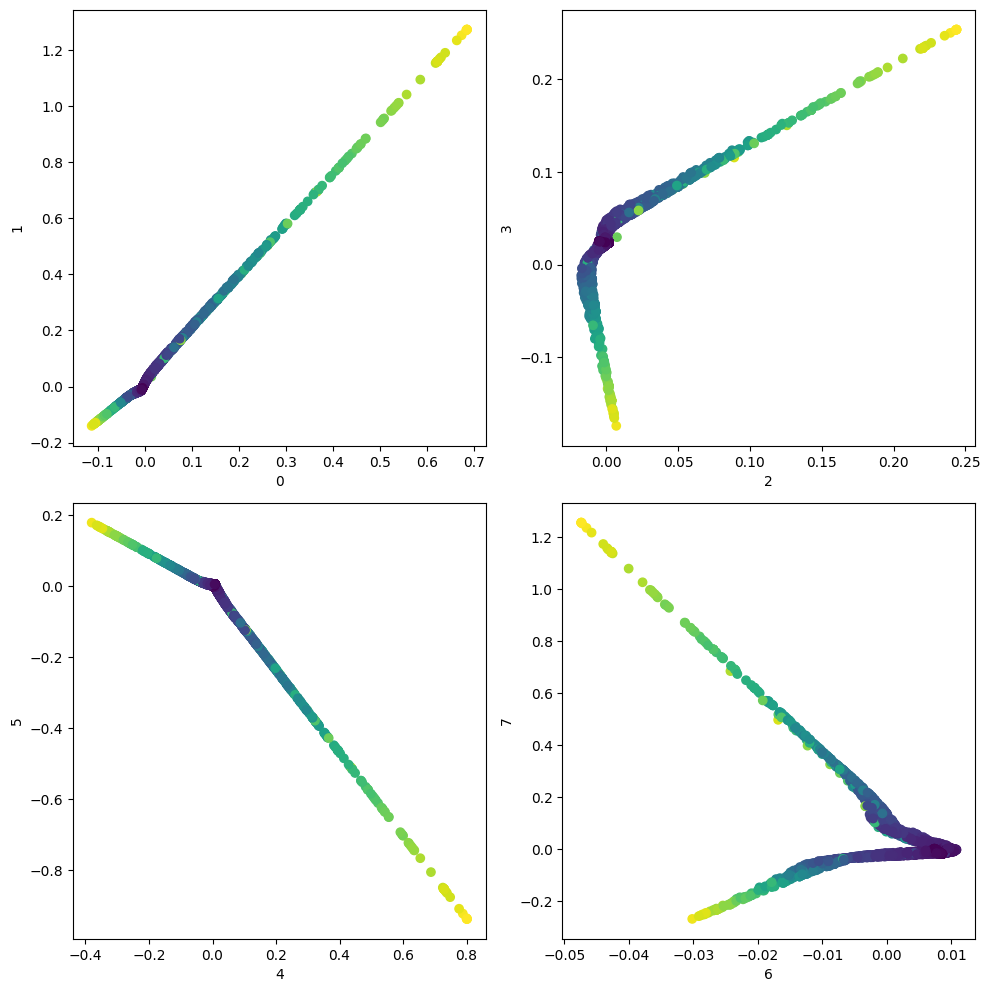

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    axs[i//2, i%2].scatter(z_graphs[:, 2*i], z_graphs[:, 2*i+1], c=stat_text[:, 3])
    axs[i//2, i%2].set_xlabel(f'{2*i}')
    axs[i//2, i%2].set_ylabel(f'{2*i+1}')
fig.tight_layout(pad=1.)

In [41]:
z_graphs_mean = z_graphs.mean(axis=0)
z_graphs_std = z_graphs.std(axis=0)
z_graphs_mean, z_graphs_std

(array([ 0.00377632,  0.01498349,  0.00180907,  0.02589554,  0.01315366,
        -0.01180411,  0.00562956,  0.01128713], dtype=float32),
 array([0.05650048, 0.10646819, 0.01901468, 0.02591432, 0.07288177,
        0.0785789 , 0.0064504 , 0.10685718], dtype=float32))

# Generate outputs using only the VAE

In [42]:
ground_truth = []
predictions = []

with open("../outputs/output_vae7_zeros.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["graph_id", "edge_list"])


    for data in test_loader:
        data = data.to(device)
        stats = data.stats
        adj = model.sample(stats)
        graph_ids = data.filename


        for i in range(stats.size(0)):
            stat_x = stats[i]

            Gs_generated = construct_nx_from_adj(adj[i,:,:].detach().cpu().numpy())
            stat_x = stat_x.detach().cpu().numpy()

            # Define a graph ID
            graph_id = graph_ids[i]

            # Convert the edge list to a single string
            edge_list_text = ", ".join([f"({u}, {v})" for u, v in Gs_generated.edges()])           
            # Write the graph ID and the full edge list as a single row
            writer.writerow([graph_id, edge_list_text])

            ground_truth.append(stat_x)
            predictions.append(gen_stats(Gs_generated))

In [43]:
mean, std = calculate_mean_std(ground_truth)
mse, mae, norm_error = evaluation_metrics(ground_truth, predictions)
mse_all, mae_all, norm_error_all = z_score_norm(ground_truth, predictions, mean, std)

In [44]:
mean

[30.35,
 222.303,
 12.816147624135017,
 1370.722,
 0.5041975271124393,
 11.393,
 3.442]

In [45]:
mae

[1.198,
 15.082,
 0.8339738619566361,
 174.92966002344667,
 0.051277789707280606,
 0.992,
 0.606]

In [46]:
mae_all

0.13177230113189273

# Train a latent diffusion model in this new latent space

In [33]:
hidden_dim_denoise = 512
n_layers_denoise = 3
n_condition = 7
dim_condition = 128
timesteps = 500
lr = 1e-3
max_epochs = 200

betas = linear_beta_schedule(timesteps=timesteps)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

denoise_model = DenoiseNN(input_dim=latent_dim + 7, hidden_dim=hidden_dim_denoise, n_layers=n_layers_denoise, n_cond=n_condition, d_cond=dim_condition).to(device)
optimizer = torch.optim.Adam(denoise_model.parameters(), lr=lr)

In [35]:
for epoch in range(1, max_epochs+1):
    denoise_model.train()
    train_loss_all = 0
    train_count = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        x_g = model.encode(data)
        z = torch.cat([x_g, data.stats], dim=1)
        t = torch.randint(0, timesteps, (x_g.size(0),), device=device).long()
        loss = p_losses(denoise_model, z, t, data.stats, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, loss_type="huber")
        loss.backward()
        train_loss_all += x_g.size(0) * loss.item()
        train_count += x_g.size(0)
        optimizer.step()

    denoise_model.eval()
    val_loss_all = 0
    val_count = 0
    for data in valid_loader:
        data = data.to(device)
        x_g = model.encode(data)
        z = torch.cat([x_g, data.stats], dim=1)
        t = torch.randint(0, timesteps, (x_g.size(0),), device=device).long()
        loss = p_losses(denoise_model, z, t, data.stats, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, loss_type="huber")
        val_loss_all += x_g.size(0) * loss.item()
        val_count += x_g.size(0)

    if epoch % 1 == 0:
        print('Epoch: {:04d}, Train Loss: {:.5f}, Val Loss: {:.5f}'.format(epoch, train_loss_all/train_count, val_loss_all/val_count))


Epoch: 0001, Train Loss: 0.43317, Val Loss: 0.43725
Epoch: 0002, Train Loss: 0.42608, Val Loss: 0.44512
Epoch: 0003, Train Loss: 0.39978, Val Loss: 0.38881
Epoch: 0004, Train Loss: 0.37732, Val Loss: 0.42338
Epoch: 0005, Train Loss: 0.35344, Val Loss: 1.13866
Epoch: 0006, Train Loss: 0.33483, Val Loss: 0.48588
Epoch: 0007, Train Loss: 0.31815, Val Loss: 0.34323
Epoch: 0008, Train Loss: 0.29873, Val Loss: 0.30957
Epoch: 0009, Train Loss: 0.27945, Val Loss: 0.30885
Epoch: 0010, Train Loss: 0.26661, Val Loss: 0.29353
Epoch: 0011, Train Loss: 0.25475, Val Loss: 0.28194
Epoch: 0012, Train Loss: 0.23825, Val Loss: 0.26988
Epoch: 0013, Train Loss: 0.23041, Val Loss: 0.27928
Epoch: 0014, Train Loss: 0.22213, Val Loss: 0.29260
Epoch: 0015, Train Loss: 0.21939, Val Loss: 0.28998
Epoch: 0016, Train Loss: 0.20893, Val Loss: 0.25800
Epoch: 0017, Train Loss: 0.20149, Val Loss: 0.26848
Epoch: 0018, Train Loss: 0.19545, Val Loss: 0.22462
Epoch: 0019, Train Loss: 0.18935, Val Loss: 0.24015
Epoch: 0020,

# Generate outputs using the latent diffusion model

In [42]:
with open("../outputs/output_ldm7.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["graph_id", "edge_list"])


    for k, data in enumerate(test_loader):
        data = data.to(device)
        
        stat = data.stats
        bs = stat.size(0)

        graph_ids = data.filename

        samples = sample(denoise_model, data.stats, latent_dim=latent_dim + 7, timesteps=timesteps, betas=betas, batch_size=bs)
        x_sample = samples[-1]
        adj = model.decode_mu(x_sample)
        stat_d = torch.reshape(stat, (-1, n_condition))


        for i in range(stat.size(0)):
            stat_x = stat_d[i]

            Gs_generated = construct_nx_from_adj(adj[i,:,:].detach().cpu().numpy())
            stat_x = stat_x.detach().cpu().numpy()

            # Define a graph ID
            graph_id = graph_ids[i]

            # Convert the edge list to a single string
            edge_list_text = ", ".join([f"({u}, {v})" for u, v in Gs_generated.edges()])           
            # Write the graph ID and the full edge list as a single row
            writer.writerow([graph_id, edge_list_text])